# Pre-processing Bill's Text Data

## Import Python Packages

In [43]:
# For loading, manipulating dataframe.
import pandas as pd
import sqlite3

# For Text Preprocessing
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer

# For visualization
from wordcloud import WordCloud
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns


# ML Modeling packages
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection as ms
import sklearn.metrics
from sklearn.metrics import classification_report

# Hide Warning messages
import warnings
warnings.filterwarnings('ignore')

## Load Philippines' Bills Data

In [44]:
con = sqlite3.connect("phBills.db")
df = pd.read_sql_query("SELECT * from senateBills", con, index_col = 'bill_id', parse_dates = ['date_filed','date_lastUpdate'])
con.close()

## EDA

In [45]:
df['Passed']=np.where(df.ra!='',True, False)

In [46]:
df['long_title']=df['long_title'].str.lower()

In [47]:
df_13_17_all = df[df['congress']!=18]

In [48]:
df_num_rows, df_num_col = df.shape
print(f"There are {df_num_rows} records and {df_num_col} features on our original data frame.")
bill_passage_rate = (df_13_17_all['ra']!='').sum()/(df_13_17_all.shape[0])
print(f"From 13th Congress to 17th Congress, the PH Bill Passage Rate is {(bill_passage_rate*100):.2f}%")

There are 16284 records and 15 features on our original data frame.
From 13th Congress to 17th Congress, the PH Bill Passage Rate is 2.89%


## Text Preprocessing

### Tokenizer

In [49]:
df_13_17_all['long_title'] = df_13_17_all['long_title'].map(word_tokenize)

### Lemmatizer

In [50]:
lemmatizer = WordNetLemmatizer()

In [51]:
df_13_17_all['long_title_lem'] = df_13_17_all['long_title'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
df_13_17_all['long_title_lem'] = df_13_17_all['long_title_lem'].apply(lambda x: ' '.join(x))

### Divide Proposed Laws (Pass or Not)

In [52]:
df_13_17_passed = df_13_17_all[df_13_17_all['Passed']==True]
df_13_17_failed = df_13_17_all[df_13_17_all['Passed']==False]

## Bag of Words – TFID Vectorizer

### Creating Vectorizer Instances

#### All Bills Vectorizer

In [53]:
vectorizer_13_17_all = TfidfVectorizer(min_df=10, max_df=0.90)
vectorizer_13_17_all.fit(df_13_17_all['long_title_lem'].values.astype('U'))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.9, max_features=None,
                min_df=10, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

#### Passed Bill Vectorizer

In [54]:
vectorizer_13_17_passed = TfidfVectorizer(min_df=10, max_df=0.90)
vectorizer_13_17_passed.fit(df_13_17_passed['long_title_lem'].values.astype('U'))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.9, max_features=None,
                min_df=10, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

#### Pending Bill Vectorizer

In [55]:
vectorizer_13_17_failed = TfidfVectorizer(min_df=10, max_df=0.90)
vectorizer_13_17_failed.fit(df_13_17_failed['long_title_lem'].values.astype('U'))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.9, max_features=None,
                min_df=10, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

## Word Clouds

### Proposed Laws Word Cloud

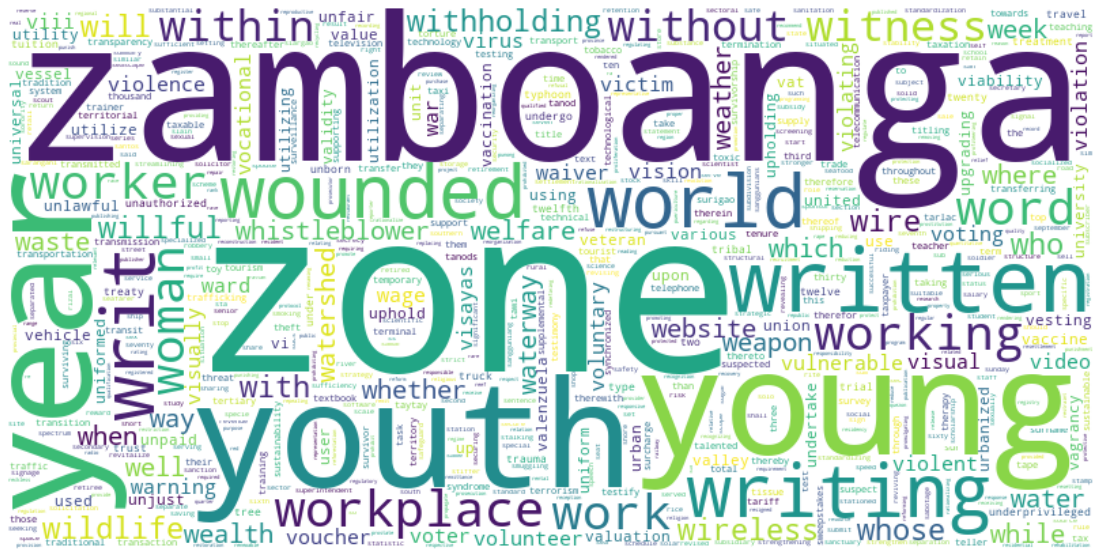

In [56]:
wc = WordCloud(width=800, height=400, max_words = 1000,stopwords=stopwords, background_color='white')
wc.generate_from_frequencies(frequencies=vectorizer_13_17_all.vocabulary_)
plt.style.use('seaborn-dark')
plt.figure( figsize=(20,10) )
plt.axis("off")
plt.imshow(wc, interpolation="bilinear");

### Passed Laws Word Cloud

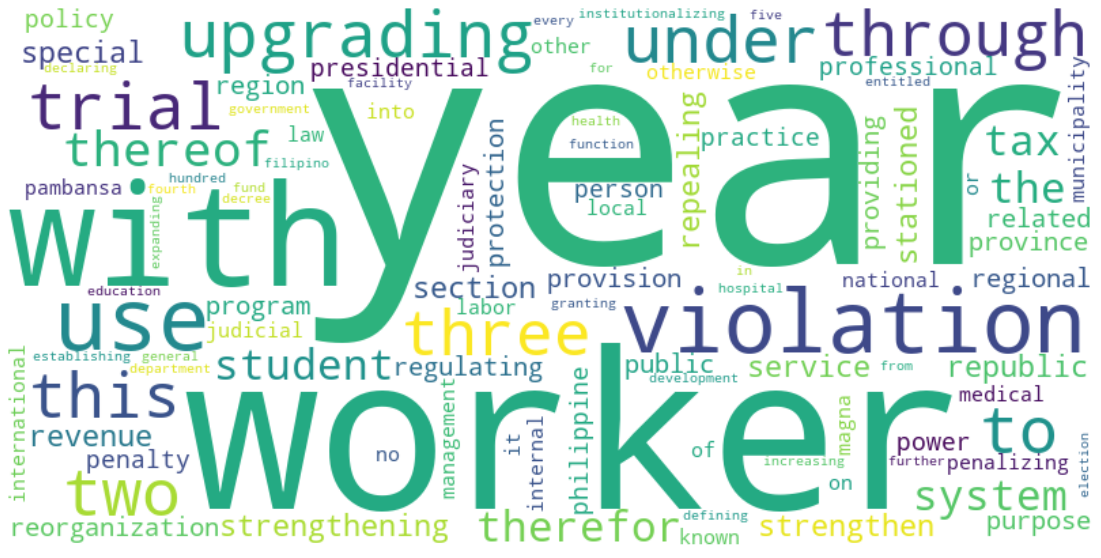

In [57]:
wc = WordCloud(width=800, height=400, max_words = 100,stopwords=stopwords, background_color='white')
wc.generate_from_frequencies(frequencies=vectorizer_13_17_passed.vocabulary_)
plt.figure( figsize=(20,10) )
plt.axis("off")
plt.imshow(wc, interpolation="bilinear");

### Pending Bills Word Cloud

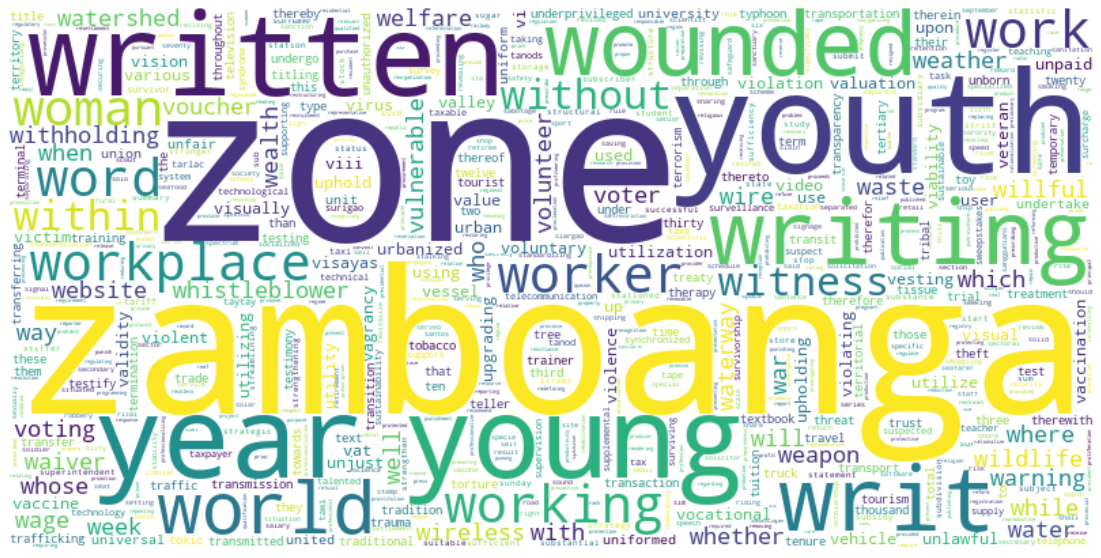

In [58]:
wc = WordCloud(width=800, height=400, max_words = 1000,stopwords=stopwords, background_color='white')
wc.generate_from_frequencies(frequencies=vectorizer_13_17_failed.vocabulary_)
plt.figure( figsize=(20,10) )
plt.axis("off")
plt.imshow(wc, interpolation="bilinear");

## Machine Learning Modeling

### Preparing our Data Sets

#### Splitting Data Into Train & Test Sets

In [59]:
X_train, X_test, y_train, y_test = train_test_split(df_13_17_all['long_title_lem'].values.astype('U'), 
                                                    df_13_17_all['Passed'], test_size = 0.25, random_state=43)
print(f"Our train set has {X_train.shape[0]:,} data points whilst our test set has {X_test.shape[0]:,} data points.")

Our train set has 11,348 data points whilst our test set has 3,783 data points.


#### Sampling Technique

In [60]:
# Under sample the majority target variable, so that we get about equal number of observations from both classes.
rus = RandomUnderSampler(random_state=42)
nx_train, ny_train = rus.fit_resample(X_train.reshape(-1,1), y_train)
print(f"Our new train set has {ny_train.shape[0]} data points, {np.sum(ny_train)} of which are actual positives.")

Our new train set has 644 data points, 322 of which are actual positives.


#### Vectorizing Train Text Feature

In [61]:
vectorizer_model = TfidfVectorizer(min_df=10, max_df=0.90)
nx_train_matrix = vectorizer_model.fit_transform(nx_train.ravel())
new_x = nx_train_matrix

### Using SVC

In [63]:
svc = SVC(gamma='auto', kernel='linear', random_state = 42)

#### Fit Model Using Train Set

In [64]:
svc.fit(new_x, ny_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

#### Predictions Using New Model

##### On Train Set

In [75]:
predicted_train = svc.predict(new_x)

##### On Test Set

In [66]:
nx_test_matrix = vectorizer_model.transform(X_test)

In [74]:
predicted = svc.predict(nx_test_matrix)

#### Model Evaluation

##### On Train Set

In [68]:
print(classification_report(ny_train, predicted_train))

              precision    recall  f1-score   support

       False       0.74      0.75      0.75       322
        True       0.75      0.74      0.74       322

    accuracy                           0.74       644
   macro avg       0.74      0.74      0.74       644
weighted avg       0.74      0.74      0.74       644



##### On Test Set

In [69]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

       False       0.98      0.63      0.77      3667
        True       0.05      0.62      0.09       116

    accuracy                           0.63      3783
   macro avg       0.52      0.63      0.43      3783
weighted avg       0.95      0.63      0.75      3783

